In [1]:
using Flux

In [2]:
using Random
using Statistics
using Plots

In [54]:
# Generate dataset of NN matricies W and H and their product V
#set seed
Random.seed!(314)

# V ∈ R^(m × n), and r is the (low) rank of V
m, n = 15, 15
r = 5
true_W = abs.(randn((m, r)))

train_set_size = 5
test_set_size  = 1

train_H = [abs.(randn((r, n))) for _ ∈ 1:train_set_size]
test_H  = [abs.(randn((r, n))) for _ ∈ 1:test_set_size ]
train_V = [true_W*train_H[i]   for i ∈ 1:train_set_size]
test_V  = [true_W*test_H[i]    for i ∈ 1:test_set_size ];

# LATER can add small noise

1-element Vector{Matrix{Float64}}:
 [4.550121595210181 1.700274660121937 … 5.254907657778933 2.083064155509878; 3.8471541142042067 3.1283424181052757 … 3.8738437723677883 2.6841725312646405; … ; 1.8203071153870078 1.3698744445597113 … 2.0898543043652213 0.53601649623376; 4.384254098580098 2.4411220123602884 … 5.715499758606215 2.2778623971890495]

In [61]:
# Define the model (copied from https://fluxml.ai/Flux.jl/stable/models/advanced/)
struct MyLayer
    W
end

W_init = abs.(randn((m,r))) #use the same random initialization
function MyLayer(m,r) # TODO add type stable-ness
    W = W_init # TODO adjust initialization
    MyLayer(W)
end

function (a::MyLayer)((H, V)) #must pass a single item into chains, that is why (H,V) are grouped
    W = a.W
    return (H .* (W'*V) ./ (W'*W*H), V) #one update step
    # TODO can add regularization later
end
#Flux.trainable(a::MyLayer) = (a.W,) #Flux.trainable(a.W) #
Flux.@functor MyLayer (W,) #declare the weights W as trainable parameters

#function (a::MyLayer)(A::Matrix{Float64})

struct MyModel
    chain::Chain
end

H_guess = abs.(randn((r,n))) # same random guess for all inputs

# this is automatic from the struct
#function MyModel(chain::Chain)
#    MyModel(chain) 
#end

function (m::MyModel)(V::Matrix{Float64}, H_guess=H_guess)
    H_out, V_out = m.chain((H_guess, V)) #must pass a single item into chains
    return H_out #just care about the first entry
end

function (m::MyModel)(V::Vector{Matrix{Float64}}) #TODO update Float64 to something more general
    return m.(V) #apply m to all elements in V
end
  
# Call @functor to allow for training. Described below in more detail.
Flux.@functor MyModel

my_layer = MyLayer(m,r)
chain = Chain([my_layer, my_layer, my_layer]) #three layer network, each layer shares parameters
model = MyModel(chain)

MyModel(Chain([MyLayer([0.4278632063043588 0.6429971968659726 … 1.216700750641024 0.4271368780569816; 0.8461358853796541 1.903141463310958 … 0.39661485208133535 2.9900808462478694; … ; 0.8594475778460126 1.8840740477398277 … 0.15848285891602495 0.9504938889534156; 0.21244860332949134 0.3365018073900978 … 2.892539243449278 0.5454956335974683]), MyLayer([0.4278632063043588 0.6429971968659726 … 1.216700750641024 0.4271368780569816; 0.8461358853796541 1.903141463310958 … 0.39661485208133535 2.9900808462478694; … ; 0.8594475778460126 1.8840740477398277 … 0.15848285891602495 0.9504938889534156; 0.21244860332949134 0.3365018073900978 … 2.892539243449278 0.5454956335974683]), MyLayer([0.4278632063043588 0.6429971968659726 … 1.216700750641024 0.4271368780569816; 0.8461358853796541 1.903141463310958 … 0.39661485208133535 2.9900808462478694; … ; 0.8594475778460126 1.8840740477398277 … 0.15848285891602495 0.9504938889534156; 0.21244860332949134 0.3365018073900978 … 2.892539243449278 0.545495633597

In [70]:
Flux.params(model)

Params([[0.4115249536995081 0.6531658733208218 … 1.2264059805030927 0.4366557192336082; 0.8496147868867849 1.8956647370334645 … 0.38397346504772767 2.9860620666968303; … ; 0.8724656397652593 1.8803988255033879 … 0.153884329222949 0.9428196418305002; 0.1934320442941226 0.344137986588142 … 2.9029191819595486 0.5461117951159213]])

In [36]:
chain

Chain([MyLayer([0.32322489523131515 0.20890335796687168 … 0.8319460245595186 0.1389041136084589; 0.5608099082170206 0.2019546558428228 … 1.3784238420119292 0.4299032072649941; … ; 1.5569142951567172 0.6785787734777858 … 0.6164140544653817 2.094932025842068; 1.0940114432675314 0.9315699182534981 … 0.4038024241560579 0.3619772429186933]), MyLayer([0.32322489523131515 0.20890335796687168 … 0.8319460245595186 0.1389041136084589; 0.5608099082170206 0.2019546558428228 … 1.3784238420119292 0.4299032072649941; … ; 1.5569142951567172 0.6785787734777858 … 0.6164140544653817 2.094932025842068; 1.0940114432675314 0.9315699182534981 … 0.4038024241560579 0.3619772429186933]), MyLayer([0.32322489523131515 0.20890335796687168 … 0.8319460245595186 0.1389041136084589; 0.5608099082170206 0.2019546558428228 … 1.3784238420119292 0.4299032072649941; … ; 1.5569142951567172 0.6785787734777858 … 0.6164140544653817 2.094932025842068; 1.0940114432675314 0.9315699182534981 … 0.4038024241560579 0.3619772429186933]

In [92]:
a = model(train_V)

5-element Vector{Matrix{Float64}}:
 [0.0819939261873859 0.002194700034517728 … -0.0002446257244312217 -2.671731706757028e-6; 0.0004372778801576134 -2.6005462247771797e-5 … -2.52524044962398e-5 -0.00015159415043728257; … ; 2.2733217828709576e-5 -0.0024539181221530635 … -0.016207738916331104 -0.005919788660726738; -0.04511764999982195 -0.07909916857801809 … -0.06065909692889621 -0.0002569431475481025]
 [0.0027968391532558943 0.0007792436099975826 … 0.018320561080555433 0.006692570329537972; -2.484694065049726e-5 -7.177782127093705e-5 … 0.0008127981159274906 -8.989155112164617e-5; … ; -0.005443104158854067 -0.007681564653046051 … -0.0004510488195091373 -0.0011618887724524738; -0.20284438520770848 -0.21936400974227072 … -0.029950388761808153 -0.00015115611111973844]
 [0.10328553208189388 0.000620180208665527 … 0.028916078252703443 5.678234081183e-7; 4.1136348403870445e-5 8.719002196614637e-6 … -0.00017865233443055046 1.4712511533805236e-11; … ; -0.0009813275135758988 -0.0017190423106363236

In [91]:
a = model(train_V)

5-element Vector{Matrix{Float64}}:
 [0.0819939261873859 0.002194700034517728 … -0.0002446257244312217 -2.671731706757028e-6; 0.0004372778801576134 -2.6005462247771797e-5 … -2.52524044962398e-5 -0.00015159415043728257; … ; 2.2733217828709576e-5 -0.0024539181221530635 … -0.016207738916331104 -0.005919788660726738; -0.04511764999982195 -0.07909916857801809 … -0.06065909692889621 -0.0002569431475481025]
 [0.0027968391532558943 0.0007792436099975826 … 0.018320561080555433 0.006692570329537972; -2.484694065049726e-5 -7.177782127093705e-5 … 0.0008127981159274906 -8.989155112164617e-5; … ; -0.005443104158854067 -0.007681564653046051 … -0.0004510488195091373 -0.0011618887724524738; -0.20284438520770848 -0.21936400974227072 … -0.029950388761808153 -0.00015115611111973844]
 [0.10328553208189388 0.000620180208665527 … 0.028916078252703443 5.678234081183e-7; 4.1136348403870445e-5 8.719002196614637e-6 … -0.00017865233443055046 1.4712511533805236e-11; … ; -0.0009813275135758988 -0.0017190423106363236

In [7]:
# Train the model
using Flux: mse
loss(model, V_input, H_truth) = mean(mse.(model(V_input), H_truth)) # mean squared error
                                                                    # the outer mean is to handle batches
# TODO idealy the model can be applied on batches without needing the elementwise application dot here
#loss(model, train_V, train_H)

using Flux: train!

opt = Descent() #or Adam(), see https://fluxml.ai/Flux.jl/stable/training/optimisers/ for full list

Descent(0.1)

In [14]:
typeof(data)

Base.Iterators.Zip{Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}}}

In [17]:
#using Debugger

In [68]:
data = zip(train_V, train_H)
train!(loss, model, data, opt)  #warning: trainable(x) should now return a NamedTuple with the field names, not a Tuple

In [89]:
maxit = 1000
training_loss = zeros(1,maxit)
testing_loss  = zeros(1,maxit)
for i ∈ 1:maxit
    train!(loss, model, data, opt)
    training_loss[i] = loss(model, train_V, train_H)
    testing_loss[i]  = loss(model, test_V , test_H )
end

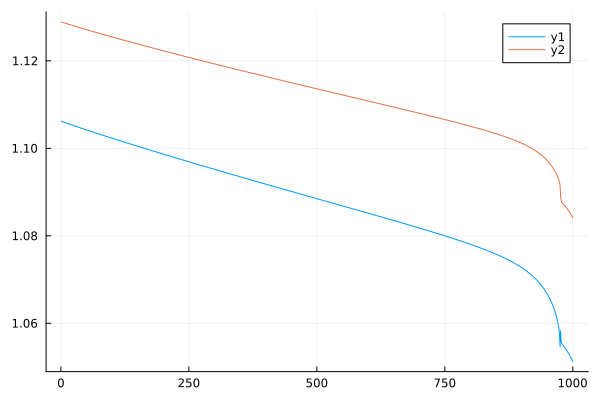

In [90]:
# Evaluate the model performance on the training and testing set
plot(1:maxit,[training_loss',testing_loss'])

In [95]:
Flux.params(model)[1]

15×5 Matrix{Float64}:
 -2.76954    -0.975986   -4.4392    -2.46514    -6.74264
  1.36963    -0.108053   -2.51423    0.473702   -1.66935
 -2.73336    -1.24336    -6.96794   -0.435409   -7.13461
  3.31511     2.34956     6.55144    4.50587     7.89741
  1.7438      1.96024     8.5663     4.37639     7.53642
  0.757794    1.9817     -0.678797   1.68581     0.835937
  2.23108     0.585744   -0.438276  -3.0963     -0.659027
  1.12851    -1.84363    -7.27963   -1.70204    -5.65885
  2.469       0.100813    0.265763   1.27212     1.33961
 -0.0369145  -0.526418   -2.76682   -0.399549   -2.95077
 -1.62156    -1.01246   -11.9021    -3.97924   -11.0253
 -1.32833    -1.07833    -4.23864   -3.72687    -6.43451
  1.2798     -0.571539   -4.32201   -1.63919    -4.04578
  1.82865     2.51899     6.0983     3.21403     6.29217
 -0.037716    1.9993      3.19539    0.957115    1.57065

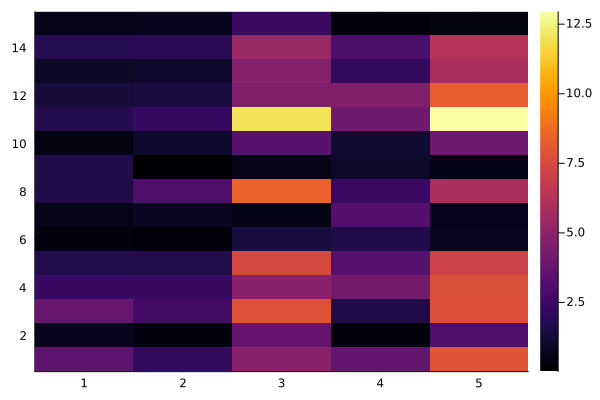

In [96]:
# Observe how close the learned weights ̂W and the true W are
learned_W = Flux.params(model)[1]
difference = abs.(learned_W - true_W)
heatmap(difference)

In [98]:
model(train_V[1])

5×15 Matrix{Float64}:
  0.0819939     0.0021947    0.000164818  …  -0.000244626  -2.67173e-6
  0.000437278  -2.60055e-5  -5.18692e-5      -2.52524e-5   -0.000151594
 -0.0174724    -0.0722067   -0.230256        -0.132234     -0.118633
  2.27332e-5   -0.00245392  -0.034462        -0.0162077    -0.00591979
 -0.0451176    -0.0790992   -0.0438932       -0.0606591    -0.000256943

In [99]:
train_H[1]

5×15 Matrix{Float64}:
 0.417054   0.791355  0.329537  0.321316   …  0.543201   0.0821013  0.0473063
 0.413354   0.354055  0.397168  0.085302      0.352863   1.14585    0.561299
 0.779789   0.269077  0.751811  0.0192033     0.633719   0.0212175  0.113677
 0.847775   0.618984  1.25798   0.0397027     0.0484056  1.0779     0.460959
 0.0902536  0.672425  2.25557   0.697806      0.199252   0.831676   0.697721

In [105]:
train_V[1]

15×15 Matrix{Float64}:
 2.20894   2.62642   5.18987  1.21271   …  1.33158   3.67001   2.10633
 1.95286   2.24795   5.09957  1.241        1.48065   2.11386   1.51621
 2.7314    2.70338   4.3862   0.948137     1.78661   3.55363   1.93077
 2.08227   1.6276    2.55808  0.534182     1.7403    0.701834  0.578297
 2.01856   1.43341   3.30255  0.394634     0.987326  1.9006    1.0872
 1.49113   1.237     1.59644  0.364785  …  1.32108   2.15807   1.15428
 1.34872   1.86951   1.21781  0.662869     1.41503   1.78144   0.883324
 3.10812   3.48831   3.66578  1.2092       2.68721   2.55766   1.41442
 1.34824   1.70219   3.26928  0.917305     1.17192   1.26218   0.934566
 1.4352    1.76155   3.99366  0.952872     0.94813   2.26408   1.42983
 0.815307  1.86768   4.94415  1.49099   …  0.942865  3.04968   2.05887
 1.27508   1.95299   5.49145  1.32504      0.722038  2.83154   1.88095
 1.23463   2.11514   5.36189  1.4818       1.03318   2.57907   1.81446
 1.06385   0.662143  1.30595  0.146358     0.728783 

In [112]:
learned_W * model(train_V[1])

15×15 Matrix{Float64}:
  0.154207    0.853873    1.40265   …   0.225515    1.03667     0.543118
  0.231511    0.315435    0.636096      0.195607    0.425717    0.295909
  0.21897     1.06257     1.93219       0.332183    1.36193     0.831236
 -0.197833   -1.10158    -2.01001      -0.310043   -1.41927    -0.806288
 -0.345762   -1.22163    -2.45387      -0.443194   -1.66131    -1.04439
  0.0371841  -0.0196335   0.061531  …   0.0390567   0.0114941   0.0700311
  0.220513    0.0962544   0.236884      0.128277    0.147554    0.0703982
  0.474193    0.97995     1.9835        0.46628     1.33323     0.875413
  0.137433   -0.122857   -0.163431      0.0587032  -0.137627   -0.0394251
  0.178209    0.4341      0.780387      0.178863    0.551357    0.331441
  0.571901    1.73774     3.36139   …   0.666819    2.30756     1.43854
  0.254898    0.821281    1.38668       0.270146    1.01156     0.526727
  0.362701    0.638942    1.22948       0.321208    0.843197    0.52356
 -0.239327   -0.941983   -1.

In [114]:
true_W * train_H[1]

15×15 Matrix{Float64}:
 2.20894   2.62642   5.18987  1.21271   …  1.33158   3.67001   2.10633
 1.95286   2.24795   5.09957  1.241        1.48065   2.11386   1.51621
 2.7314    2.70338   4.3862   0.948137     1.78661   3.55363   1.93077
 2.08227   1.6276    2.55808  0.534182     1.7403    0.701834  0.578297
 2.01856   1.43341   3.30255  0.394634     0.987326  1.9006    1.0872
 1.49113   1.237     1.59644  0.364785  …  1.32108   2.15807   1.15428
 1.34872   1.86951   1.21781  0.662869     1.41503   1.78144   0.883324
 3.10812   3.48831   3.66578  1.2092       2.68721   2.55766   1.41442
 1.34824   1.70219   3.26928  0.917305     1.17192   1.26218   0.934566
 1.4352    1.76155   3.99366  0.952872     0.94813   2.26408   1.42983
 0.815307  1.86768   4.94415  1.49099   …  0.942865  3.04968   2.05887
 1.27508   1.95299   5.49145  1.32504      0.722038  2.83154   1.88095
 1.23463   2.11514   5.36189  1.4818       1.03318   2.57907   1.81446
 1.06385   0.662143  1.30595  0.146358     0.728783 

In [113]:
learned_W * train_H[1]

15×15 Matrix{Float64}:
  -7.71854   -9.79153   -22.9473   …   -6.12482   -9.70478    -7.02428
  -1.18309   -0.46022    -4.65123      -1.19715   -0.942468   -1.22805
  -8.10048   -9.54519   -23.2735       -7.78187   -8.19997    -6.79797
  11.9953    13.3176     30.4325        8.5733    14.5284      9.80759
  12.6078    12.1556     30.2978        8.78104   13.5563      9.43222
   2.1105     2.72426     4.53269  …    0.9289     4.83092     2.43135
  -1.85361   -0.504672   -4.74321       0.85968   -3.04056    -1.50259
  -7.92167   -6.57717   -20.7383       -5.8607    -8.7153     -6.54184
   2.47799    3.74927     5.67535       1.87365    2.80921     1.72466
  -2.99557   -3.19157    -9.45966      -2.56648   -3.54969    -2.85474
 -14.7445   -14.721     -39.7587   …  -11.1701   -15.0045    -11.5248
  -8.04525   -9.20709   -23.2545       -5.25065  -10.8032     -7.35737
  -4.82756   -4.08765   -14.2422       -3.13089   -5.7732     -4.33
   9.85194   10.2003     24.4235        7.1561    11.8634 